In [213]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [15]:

import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from pts.dataset import recipe as rcp

from pts.dataset.artificial import RecipeDataset
from pts.dataset import FileDataset, MetaData

from pts.dataset.repository import get_dataset
from pts.evaluation import make_evaluation_predictions, Evaluator
from pts.model.deepar import DeepAREstimator
from pts.model.simple_feedforward import SimpleFeedForwardEstimator
from pts.modules import (
    ImplicitQuantileOutput,
    PiecewiseLinearOutput,
)
from pts import Trainer



TIME_SERIE_LENGTH = 3 * 10 
PREDICTION_LENGTH = 3 
NUMBER_OF_TIME_SERIES = 2000

NUM_EPOCHS = 20
NUM_BATCHES_PER_EPOCH = 16
NUM_TRAININGS = 5
NUM_SAMPLES = 100
BATCH_SIZE = 64 * 2


        
def write_to_file(recipe, length, num_ts, file_name):
    with open("{}.json".format(file_name), 'w') as f:
        for x in islice(rcp.generate(length, recipe, "2019-01-07 00:00"), num_ts):
            z = {}
            for k in x:
                if type(x[k]) == np.ndarray:
                    z[k] = x[k].tolist()
                else:
                    z[k] = x[k]
            f.write(json.dumps(z))
            f.write('\n')

class RandomNegativeBinomial(rcp.Lifted):
    def __init__(self, n, p):
        self.n = n
        self.p = p
        
    def __call__(self, x, length, *args, **kwargs):
        return np.random.negative_binomial(self.n, self.p, length)
    
    
class RandomInflatedUniform(rcp.Lifted):
    def __init__(self, p_0, p_1):
        assert (p_0 + p_1 <= 1) and (p_0>=0) and (p_1>=0)
        self.p_0 = p_0
        self.p_1 = p_1
        self.p_uniform = 1 - p_0 - p_1
        
    def __call__(self, x, length, *args, **kwargs):
        result = np.zeros((length,))
        for i in range(length):
            c = np.random.choice([0, 1, 2], p=[self.p_0, self.p_1, self.p_uniform])
            if c == 1:
                result[i] = 1.
            elif c == 2: 
                result[i] = np.random.uniform()
        return result
            
class RandomGaussianMixture(rcp.Lifted):
    def __init__(
            self, mean, stddev, mixture_coef, shape=(0,)
    ) -> None:
        self.stddev = np.array(stddev).reshape(1, -1)
        self.mean = np.array(mean).reshape(1, -1)
        self.mixture_coef = mixture_coef
        self.shape = shape

    def __call__(self, x, length: int, *args, **kwargs):
        s = [length, self.stddev.shape[0]]
        choices = np.random.choice([0, 1, 2], p=self.mixture_coef, size=(length, ))
        all_samples = self.stddev * np.random.randn(*s) + self.mean
        result = np.zeros((length,))
        for i in range(length):
            c = choices[i]
            result[i] = all_samples[i, c]
        return result
        
        
DATASET_REFERENCES = {
#     "uniform": rcp.RandomUniform(),
#     "gaussian(4, 10)": 4 + rcp.RandomGaussian(stddev=10),
#     "negative_binomial(10, 0.2)": RandomNegativeBinomial(10, 0.2)
#     "random_int(0, 4)": rcp.RandomInteger(low=0., high=4.),
#     "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
    "inflated_uniform(0.5, 0.)": RandomInflatedUniform(0.5, 0.),
    "inflated_uniform(0., 0.5)": RandomInflatedUniform(0., 0.5),
    "inflated_uniform(0.25, 0.25)": RandomInflatedUniform(0.25, 0.25),
    "inflated_uniform(0.30, 0.10)": RandomInflatedUniform(0.30, 0.10),
}    

META_DATA = MetaData(freq="H", prediction_length=PREDICTION_LENGTH)

for fn in DATASET_REFERENCES:
    recipe = [("input", 1.), ("target", DATASET_REFERENCES[fn])]
    
    write_to_file(recipe, length=TIME_SERIE_LENGTH, num_ts=NUMBER_OF_TIME_SERIES, file_name=fn)



In [16]:
def run_one_training(dataset, distr_output, metadata=META_DATA):
#     estimator = SimpleFeedForwardEstimator(
#         distr_output=distr_output,
#         freq=metadata.freq,
#         prediction_length=metadata.prediction_length,
#         num_hidden_dimensions=[10],
# #         context_length=CONTEXT_LENGTH,
#         trainer=Trainer(device="cpu",
#                         epochs=NUM_EPOCHS,
#                         learning_rate=1e-3,
#                         num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
#                         batch_size=BATCH_SIZE,
#                         num_workers=1,
#                         ),
#     )

    estimator = DeepAREstimator(
        distr_output=distr_output,
        freq=metadata.freq,
        prediction_length=metadata.prediction_length,
        trainer=Trainer(device="cpu",
                        epochs=NUM_EPOCHS,
                        learning_rate=1e-3,
                        num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                        batch_size=BATCH_SIZE,
#                         num_workers=1,
                        ),
        input_size=48,
    )
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))
    
    all_quantiles_df = pd.DataFrame(
        [
            [forecasts[item_id].quantile(q/100.)[0] for q in range(0, 100)] 
            for item_id in range(len(forecasts))
        ]
    )
    sampled_quantiles = all_quantiles_df.mean(axis=0)
    return estimator, agg_metrics, sampled_quantiles


def run_several_training(dataset, distr_output, num_trainings=NUM_TRAININGS):
    estimators = []
    all_agg_metrics = []
    all_sampled_quantiles = []
    for i in range(num_trainings):
        estimator, agg_metrics, sampled_quantiles = run_one_training(dataset, distr_output)
        estimators.append(estimator)
        all_agg_metrics.append(agg_metrics)
        all_sampled_quantiles.append(sampled_quantiles)
        
    return estimators, all_agg_metrics, all_sampled_quantiles


store_results = {}
distr_outputs = {
    'iqn': ImplicitQuantileOutput(output_domain="Real"),
    'piecewiseLinear_10': PiecewiseLinearOutput(num_pieces=10),
#     'piecewiseLinear_20': PiecewiseLinearOutput(num_pieces=20),
    'piecewiseLinear_30': PiecewiseLinearOutput(num_pieces=30),
}


for fn in DATASET_REFERENCES:
    dataset = FileDataset("{}.json".format(fn), META_DATA.freq, shuffle=True)
    for dn in distr_outputs:
        distr_output = distr_outputs[dn]
        estimators, all_agg_metrics, all_sampled_quantiles = run_several_training(dataset, distr_output)
        store_results[(fn, dn)] = {
            "estimators": estimators,
            "all_agg_metrics": all_agg_metrics, 
            "all_sampled_quantiles": all_sampled_quantiles,
        }
        





15it [00:00, 18.63it/s, avg_epoch_loss=0.135, epoch=0]
15it [00:00, 17.91it/s, avg_epoch_loss=0.12, epoch=1] 
15it [00:00, 17.07it/s, avg_epoch_loss=0.12, epoch=2] 
15it [00:00, 19.06it/s, avg_epoch_loss=0.118, epoch=3]
15it [00:00, 20.24it/s, avg_epoch_loss=0.111, epoch=4]
15it [00:00, 18.29it/s, avg_epoch_loss=0.1, epoch=5]  
15it [00:00, 16.11it/s, avg_epoch_loss=0.0911, epoch=6]
15it [00:00, 20.29it/s, avg_epoch_loss=0.0861, epoch=7]
15it [00:00, 21.24it/s, avg_epoch_loss=0.0862, epoch=8]
15it [00:00, 20.85it/s, avg_epoch_loss=0.0867, epoch=9]
15it [00:00, 20.55it/s, avg_epoch_loss=0.085, epoch=10] 
15it [00:00, 23.50it/s, avg_epoch_loss=0.0858, epoch=11]
15it [00:00, 23.21it/s, avg_epoch_loss=0.0843, epoch=12]
15it [00:00, 23.10it/s, avg_epoch_loss=0.0863, epoch=13]
15it [00:00, 23.40it/s, avg_epoch_loss=0.0853, epoch=14]
15it [00:00, 23.09it/s, avg_epoch_loss=0.0862, epoch=15]
15it [00:00, 23.51it/s, avg_epoch_loss=0.0843, epoch=16]
15it [00:00, 22.14it/s, avg_epoch_loss=0.0866, 

15it [00:00, 19.66it/s, avg_epoch_loss=-.61, epoch=17] 
15it [00:00, 18.59it/s, avg_epoch_loss=-.639, epoch=18]
15it [00:00, 20.39it/s, avg_epoch_loss=-.315, epoch=19]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 23087.49it/s]
15it [00:00, 18.77it/s, avg_epoch_loss=-.144, epoch=0] 
15it [00:00, 18.68it/s, avg_epoch_loss=-.339, epoch=1]
15it [00:00, 18.63it/s, avg_epoch_loss=-.393, epoch=2]
15it [00:00, 19.85it/s, avg_epoch_loss=-.484, epoch=3]
15it [00:00, 19.21it/s, avg_epoch_loss=-.388, epoch=4]
15it [00:00, 19.36it/s, avg_epoch_loss=-.208, epoch=5]
15it [00:00, 18.54it/s, avg_epoch_loss=-.506, epoch=6]
15it [00:00, 16.04it/s, avg_epoch_loss=-.57, epoch=7] 
15it [00:01, 12.83it/s, avg_epoch_loss=-.542, epoch=8]
15it [00:00, 18.19it/s, avg_epoch_loss=-.455, epoch=9]
15it [00:00, 19.85it/s, avg_epoch_loss=-.534, epoch=10]
15it [00:00, 19.39it/s, avg_epoch_loss=-.651, epoch=11]
15it [00:00, 19.89it/s, avg_epoch_loss=-.434, epoch=12]
15it [00:00, 19.45it/s, avg_epoch_loss

15it [00:01, 13.08it/s, avg_epoch_loss=-.599, epoch=14]
15it [00:01,  8.12it/s, avg_epoch_loss=-.614, epoch=15]
15it [00:00, 18.82it/s, avg_epoch_loss=-.602, epoch=16]
15it [00:00, 18.32it/s, avg_epoch_loss=-.581, epoch=17]
15it [00:01, 10.86it/s, avg_epoch_loss=-.622, epoch=18]
15it [00:01, 14.67it/s, avg_epoch_loss=-.615, epoch=19]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 48534.23it/s]
15it [00:01, 14.45it/s, avg_epoch_loss=-.417, epoch=0]
15it [00:01, 13.47it/s, avg_epoch_loss=-.368, epoch=1]
15it [00:00, 16.61it/s, avg_epoch_loss=-.454, epoch=2]
15it [00:00, 15.07it/s, avg_epoch_loss=-.0166, epoch=3]
15it [00:01, 14.61it/s, avg_epoch_loss=-.552, epoch=4]
15it [00:01, 14.43it/s, avg_epoch_loss=-.0927, epoch=5]
15it [00:01, 14.44it/s, avg_epoch_loss=-.571, epoch=6]
15it [00:00, 15.93it/s, avg_epoch_loss=-.633, epoch=7]
15it [00:00, 15.38it/s, avg_epoch_loss=-.247, epoch=8] 
15it [00:01, 14.78it/s, avg_epoch_loss=-.541, epoch=9]
15it [00:00, 15.29it/s, avg_epoch_lo

15it [00:00, 22.32it/s, avg_epoch_loss=-.000135, epoch=10]
15it [00:00, 23.07it/s, avg_epoch_loss=-.0282, epoch=11]
15it [00:00, 22.71it/s, avg_epoch_loss=-.00347, epoch=12]
15it [00:00, 22.85it/s, avg_epoch_loss=-.0127, epoch=13]
15it [00:00, 23.12it/s, avg_epoch_loss=-.0154, epoch=14]
15it [00:00, 22.98it/s, avg_epoch_loss=-.0339, epoch=15]
15it [00:00, 22.57it/s, avg_epoch_loss=-.0404, epoch=16]
15it [00:00, 22.94it/s, avg_epoch_loss=-.0301, epoch=17] 
15it [00:00, 22.55it/s, avg_epoch_loss=-.0468, epoch=18]
15it [00:00, 22.53it/s, avg_epoch_loss=-.0357, epoch=19]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 68298.90it/s]
15it [00:00, 18.13it/s, avg_epoch_loss=0.439, epoch=0]
15it [00:01, 13.66it/s, avg_epoch_loss=0.275, epoch=1]
15it [00:01, 14.76it/s, avg_epoch_loss=0.064, epoch=2] 
15it [00:01, 14.47it/s, avg_epoch_loss=0.006, epoch=3]  
15it [00:01, 14.31it/s, avg_epoch_loss=0.228, epoch=4] 
15it [00:01, 12.99it/s, avg_epoch_loss=0.0113, epoch=5]
15it [00:00, 18.

15it [00:01, 15.00it/s, avg_epoch_loss=0.0725, epoch=5]
15it [00:00, 15.21it/s, avg_epoch_loss=-.0144, epoch=6]
15it [00:01, 14.87it/s, avg_epoch_loss=0.0452, epoch=7]
15it [00:00, 19.77it/s, avg_epoch_loss=-.0171, epoch=8]
15it [00:00, 19.27it/s, avg_epoch_loss=0.0644, epoch=9]
15it [00:00, 16.98it/s, avg_epoch_loss=0.00354, epoch=10]
15it [00:00, 16.56it/s, avg_epoch_loss=-.0209, epoch=11]
15it [00:00, 16.49it/s, avg_epoch_loss=-.0362, epoch=12]
15it [00:00, 19.14it/s, avg_epoch_loss=-.0108, epoch=13] 
15it [00:00, 18.90it/s, avg_epoch_loss=-.031, epoch=14] 
15it [00:00, 16.94it/s, avg_epoch_loss=-.048, epoch=15] 
15it [00:00, 16.51it/s, avg_epoch_loss=-.0518, epoch=16]
15it [00:01, 14.01it/s, avg_epoch_loss=-.0529, epoch=17]
15it [00:01, 13.69it/s, avg_epoch_loss=0.169, epoch=18]
15it [00:00, 19.77it/s, avg_epoch_loss=-.0543, epoch=19]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 42920.34it/s]
15it [00:01, 13.03it/s, avg_epoch_loss=0.23, epoch=0] 
15it [00:01, 13.24i

15it [00:00, 22.55it/s, avg_epoch_loss=0.126, epoch=1]
15it [00:00, 21.46it/s, avg_epoch_loss=0.121, epoch=2]
15it [00:00, 22.49it/s, avg_epoch_loss=0.12, epoch=3]
15it [00:00, 22.51it/s, avg_epoch_loss=0.118, epoch=4]
15it [00:00, 21.44it/s, avg_epoch_loss=0.118, epoch=5]
15it [00:00, 22.48it/s, avg_epoch_loss=0.116, epoch=6]
15it [00:00, 22.07it/s, avg_epoch_loss=0.118, epoch=7]
15it [00:00, 21.94it/s, avg_epoch_loss=0.116, epoch=8]
15it [00:00, 22.22it/s, avg_epoch_loss=0.117, epoch=9]
15it [00:00, 22.30it/s, avg_epoch_loss=0.113, epoch=10]
15it [00:00, 21.90it/s, avg_epoch_loss=0.115, epoch=11]
15it [00:00, 21.66it/s, avg_epoch_loss=0.115, epoch=12]
15it [00:00, 21.66it/s, avg_epoch_loss=0.116, epoch=13]
15it [00:00, 21.78it/s, avg_epoch_loss=0.115, epoch=14]
15it [00:00, 21.82it/s, avg_epoch_loss=0.115, epoch=15]
15it [00:00, 21.29it/s, avg_epoch_loss=0.113, epoch=16]
15it [00:00, 21.34it/s, avg_epoch_loss=0.115, epoch=17]
15it [00:00, 22.75it/s, avg_epoch_loss=0.115, epoch=18]
15

15it [00:00, 18.34it/s, avg_epoch_loss=-.159, epoch=19]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 49559.02it/s]
15it [00:00, 17.88it/s, avg_epoch_loss=0.135, epoch=0]
15it [00:00, 18.30it/s, avg_epoch_loss=-.0209, epoch=1]
15it [00:00, 19.06it/s, avg_epoch_loss=-.0505, epoch=2]
15it [00:00, 18.71it/s, avg_epoch_loss=-.0533, epoch=3]
15it [00:00, 18.63it/s, avg_epoch_loss=-.0638, epoch=4]
15it [00:00, 18.99it/s, avg_epoch_loss=-.138, epoch=5]
15it [00:00, 18.08it/s, avg_epoch_loss=-.133, epoch=6]
15it [00:00, 18.41it/s, avg_epoch_loss=-.142, epoch=7]
15it [00:00, 19.85it/s, avg_epoch_loss=-.176, epoch=8]
15it [00:00, 15.14it/s, avg_epoch_loss=0.356, epoch=9]
15it [00:00, 17.44it/s, avg_epoch_loss=-.155, epoch=10]
15it [00:00, 17.30it/s, avg_epoch_loss=-.188, epoch=11]
15it [00:00, 17.90it/s, avg_epoch_loss=-.191, epoch=12]
15it [00:00, 18.36it/s, avg_epoch_loss=-.198, epoch=13]
15it [00:00, 18.55it/s, avg_epoch_loss=-.157, epoch=14]
15it [00:00, 19.15it/s, avg_epoch_l

15it [00:00, 19.32it/s, avg_epoch_loss=0.106, epoch=16]
15it [00:00, 20.91it/s, avg_epoch_loss=0.106, epoch=17]
15it [00:00, 21.87it/s, avg_epoch_loss=0.105, epoch=18]
15it [00:00, 21.96it/s, avg_epoch_loss=0.103, epoch=19]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 55519.87it/s]
15it [00:00, 22.34it/s, avg_epoch_loss=0.131, epoch=0]
15it [00:00, 21.89it/s, avg_epoch_loss=0.111, epoch=1]
15it [00:00, 22.32it/s, avg_epoch_loss=0.109, epoch=2]
15it [00:00, 22.21it/s, avg_epoch_loss=0.108, epoch=3]
15it [00:00, 22.09it/s, avg_epoch_loss=0.106, epoch=4]
15it [00:00, 19.95it/s, avg_epoch_loss=0.108, epoch=5]
15it [00:00, 16.82it/s, avg_epoch_loss=0.103, epoch=6]
15it [00:00, 20.20it/s, avg_epoch_loss=0.106, epoch=7]
15it [00:00, 20.76it/s, avg_epoch_loss=0.105, epoch=8]
15it [00:00, 22.00it/s, avg_epoch_loss=0.102, epoch=9]
15it [00:00, 19.58it/s, avg_epoch_loss=0.102, epoch=10]
15it [00:00, 19.22it/s, avg_epoch_loss=0.104, epoch=11]
15it [00:00, 19.96it/s, avg_epoch_loss=

15it [00:00, 22.71it/s, avg_epoch_loss=0.777, epoch=14]
15it [00:00, 22.92it/s, avg_epoch_loss=-.338, epoch=15]
15it [00:00, 21.91it/s, avg_epoch_loss=-.364, epoch=16]
15it [00:00, 22.77it/s, avg_epoch_loss=2.54, epoch=17]
15it [00:00, 23.05it/s, avg_epoch_loss=-.287, epoch=18]
15it [00:00, 22.93it/s, avg_epoch_loss=0.788, epoch=19]
Running evaluation: 100%|██████████| 2000/2000 [00:00<00:00, 51996.58it/s]
15it [00:00, 20.16it/s, avg_epoch_loss=-.057, epoch=0] 
15it [00:00, 20.55it/s, avg_epoch_loss=-.155, epoch=1]
15it [00:00, 19.86it/s, avg_epoch_loss=0.404, epoch=2]
15it [00:00, 20.32it/s, avg_epoch_loss=-.167, epoch=3]
15it [00:00, 19.94it/s, avg_epoch_loss=-.168, epoch=4]
15it [00:00, 20.51it/s, avg_epoch_loss=0.846, epoch=5]
15it [00:00, 20.41it/s, avg_epoch_loss=-.333, epoch=6]
15it [00:00, 20.17it/s, avg_epoch_loss=-.297, epoch=7]
15it [00:00, 20.09it/s, avg_epoch_loss=-.317, epoch=8]
15it [00:00, 20.04it/s, avg_epoch_loss=-.272, epoch=9]
15it [00:00, 19.97it/s, avg_epoch_loss=

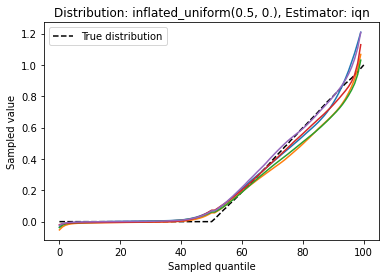

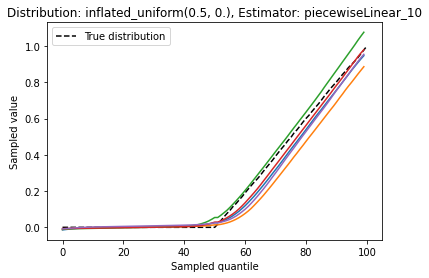

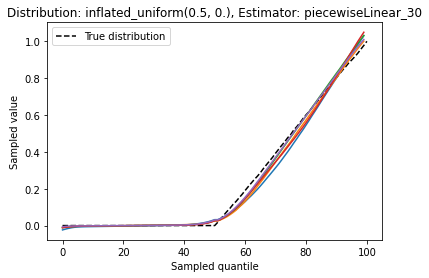

-------------------------------------------------
Distribution: inflated_uniform(0.5, 0.), Estimator: iqn


,mean,amin,amax
MASE,1.652853,1.637880,1.660678
sMAPE,1.740587,1.721686,1.775558
MSIS,8.003916,7.390113,8.536573
mean_wQuantileLoss,0.759646,0.755058,0.764342
wQuantileLoss[0.1],0.203706,0.201990,0.205944
wQuantileLoss[0.5],1.022115,1.018636,1.026277
wQuantileLoss[0.9],0.580273,0.555748,0.612391


-------------------------------------------------
Distribution: inflated_uniform(0.5, 0.), Estimator: piecewiseLinear_10


,mean,amin,amax
MASE,1.626705,1.611946,1.671125
sMAPE,1.858408,1.806430,1.914002
MSIS,8.836478,7.870784,10.247300
mean_wQuantileLoss,0.768805,0.764889,0.774997
wQuantileLoss[0.1],0.204038,0.201270,0.209370
wQuantileLoss[0.5],1.008843,1.001826,1.019963
wQuantileLoss[0.9],0.601206,0.582896,0.620439


-------------------------------------------------
Distribution: inflated_uniform(0.5, 0.), Estimator: piecewiseLinear_30


,mean,amin,amax
MASE,1.622367,1.611399,1.636606
sMAPE,1.863408,1.852802,1.876440
MSIS,8.170524,7.808737,8.419358
mean_wQuantileLoss,0.766237,0.764005,0.769473
wQuantileLoss[0.1],0.202426,0.201046,0.204782
wQuantileLoss[0.5],1.009231,1.007758,1.011984
wQuantileLoss[0.9],0.609047,0.587813,0.622240


-------------------------------------------------
Distribution: inflated_uniform(0.5, 0.), Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.053900,0.003500,0.143167
Coverage[0.2],0.198567,0.020500,0.444333
Coverage[0.3],0.311167,0.091500,0.507667
Coverage[0.4],0.428000,0.308500,0.514667
Coverage[0.5],0.536600,0.519667,0.547667
Coverage[0.6],0.609867,0.602333,0.621333
Coverage[0.7],0.696800,0.678333,0.717833
Coverage[0.8],0.780467,0.759333,0.814000
Coverage[0.9],0.875200,0.844500,0.921833
wQuantileLoss[0.1],0.203706,0.201990,0.205944


-------------------------------------------------
Distribution: inflated_uniform(0.5, 0.), Estimator: piecewiseLinear_10


,mean,amin,amax
Coverage[0.1],0.149500,0.000000,0.463167
Coverage[0.2],0.312500,0.064333,0.512833
Coverage[0.3],0.463267,0.390333,0.514500
Coverage[0.4],0.511067,0.505167,0.516333
Coverage[0.5],0.524267,0.517167,0.531833
Coverage[0.6],0.571433,0.543500,0.607333
Coverage[0.7],0.666300,0.624500,0.710500
Coverage[0.8],0.772100,0.727333,0.813667
Coverage[0.9],0.878200,0.830167,0.915833
wQuantileLoss[0.1],0.204038,0.201270,0.209370


-------------------------------------------------
Distribution: inflated_uniform(0.5, 0.), Estimator: piecewiseLinear_30


,mean,amin,amax
Coverage[0.1],0.003800,0.000000,0.014333
Coverage[0.2],0.146067,0.008333,0.279000
Coverage[0.3],0.392633,0.148000,0.507167
Coverage[0.4],0.494467,0.432833,0.511667
Coverage[0.5],0.524567,0.523333,0.525667
Coverage[0.6],0.582200,0.571167,0.589667
Coverage[0.7],0.682133,0.659333,0.697500
Coverage[0.8],0.792267,0.769667,0.811667
Coverage[0.9],0.898533,0.888833,0.905000
wQuantileLoss[0.1],0.202426,0.201046,0.204782


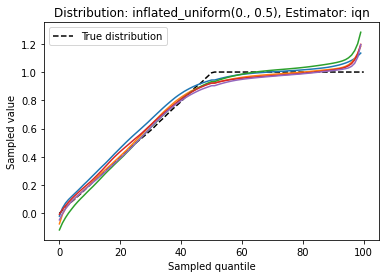

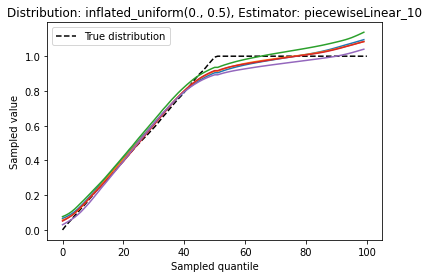

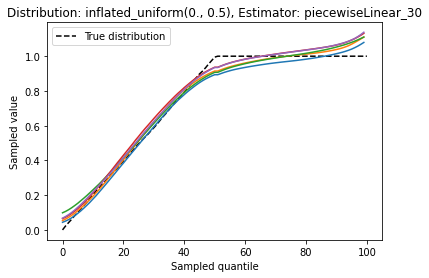

-------------------------------------------------
Distribution: inflated_uniform(0., 0.5), Estimator: iqn


,mean,amin,amax
MASE,1.767471,1.755422,1.792838
sMAPE,0.398371,0.396337,0.401426
MSIS,8.293962,8.031671,8.913911
mean_wQuantileLoss,0.252357,0.251130,0.254174
wQuantileLoss[0.1],0.178785,0.177894,0.179671
wQuantileLoss[0.5],0.336420,0.335956,0.337284
wQuantileLoss[0.9],0.075663,0.071314,0.083502


-------------------------------------------------
Distribution: inflated_uniform(0., 0.5), Estimator: piecewiseLinear_10


,mean,amin,amax
MASE,1.788239,1.751081,1.825070
sMAPE,0.400684,0.395324,0.406984
MSIS,7.996695,7.807040,8.193019
mean_wQuantileLoss,0.254800,0.252954,0.258539
wQuantileLoss[0.1],0.178269,0.177578,0.179441
wQuantileLoss[0.5],0.337509,0.334456,0.341865
wQuantileLoss[0.9],0.081858,0.077253,0.088658


-------------------------------------------------
Distribution: inflated_uniform(0., 0.5), Estimator: piecewiseLinear_30


,mean,amin,amax
MASE,1.796336,1.731766,1.835419
sMAPE,0.399945,0.396019,0.405422
MSIS,7.941756,7.548984,8.255829
mean_wQuantileLoss,0.253901,0.251872,0.255091
wQuantileLoss[0.1],0.177577,0.177129,0.178328
wQuantileLoss[0.5],0.337044,0.334844,0.339761
wQuantileLoss[0.9],0.081153,0.076894,0.084870


-------------------------------------------------
Distribution: inflated_uniform(0., 0.5), Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.107967,0.090667,0.124667
Coverage[0.2],0.207800,0.194000,0.230167
Coverage[0.3],0.310833,0.300500,0.330167
Coverage[0.4],0.404367,0.395333,0.418167
Coverage[0.5],0.471933,0.449833,0.504167
Coverage[0.6],0.556600,0.468667,0.675667
Coverage[0.7],0.672033,0.488500,0.917833
Coverage[0.8],0.801633,0.609667,0.984167
Coverage[0.9],0.962900,0.909000,0.998833
wQuantileLoss[0.1],0.178785,0.177894,0.179671


-------------------------------------------------
Distribution: inflated_uniform(0., 0.5), Estimator: piecewiseLinear_10


,mean,amin,amax
Coverage[0.1],0.103733,0.088500,0.113833
Coverage[0.2],0.201333,0.190833,0.209333
Coverage[0.3],0.306200,0.299167,0.315833
Coverage[0.4],0.398167,0.389333,0.413833
Coverage[0.5],0.457233,0.441000,0.487333
Coverage[0.6],0.521500,0.458667,0.648167
Coverage[0.7],0.655633,0.479500,0.895333
Coverage[0.8],0.806800,0.556000,0.980500
Coverage[0.9],0.924267,0.729500,0.996833
wQuantileLoss[0.1],0.178269,0.177578,0.179441


-------------------------------------------------
Distribution: inflated_uniform(0., 0.5), Estimator: piecewiseLinear_30


,mean,amin,amax
Coverage[0.1],0.103967,0.089500,0.118833
Coverage[0.2],0.202967,0.189333,0.210167
Coverage[0.3],0.306033,0.292833,0.315667
Coverage[0.4],0.396767,0.387500,0.405333
Coverage[0.5],0.465267,0.438667,0.489667
Coverage[0.6],0.562967,0.462167,0.659833
Coverage[0.7],0.725733,0.493333,0.867833
Coverage[0.8],0.848267,0.585833,0.960333
Coverage[0.9],0.948633,0.830333,0.990333
wQuantileLoss[0.1],0.177577,0.177129,0.178328


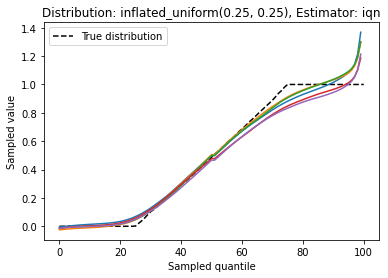

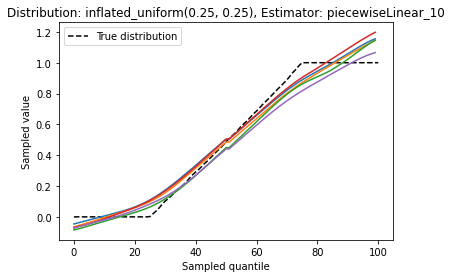

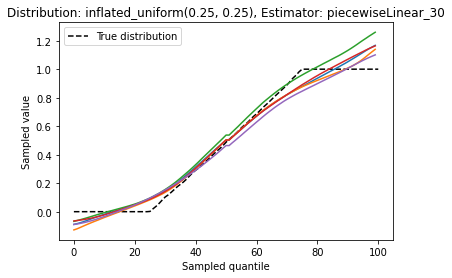

-------------------------------------------------
Distribution: inflated_uniform(0.25, 0.25), Estimator: iqn


,mean,amin,amax
MASE,1.577582,1.561737,1.608622
sMAPE,0.992017,0.983063,1.007762
MSIS,4.964704,4.687307,5.223757
mean_wQuantileLoss,0.528517,0.525858,0.531265
wQuantileLoss[0.1],0.204438,0.201432,0.210317
wQuantileLoss[0.5],0.779035,0.773208,0.783634
wQuantileLoss[0.9],0.235915,0.228829,0.244335


-------------------------------------------------
Distribution: inflated_uniform(0.25, 0.25), Estimator: piecewiseLinear_10


,mean,amin,amax
MASE,1.585086,1.566420,1.614523
sMAPE,0.993868,0.976230,1.018940
MSIS,4.946769,4.791654,5.148732
mean_wQuantileLoss,0.532310,0.530117,0.533984
wQuantileLoss[0.1],0.210473,0.208828,0.211853
wQuantileLoss[0.5],0.775632,0.773573,0.777525
wQuantileLoss[0.9],0.242407,0.237475,0.248518


-------------------------------------------------
Distribution: inflated_uniform(0.25, 0.25), Estimator: piecewiseLinear_30


,mean,amin,amax
MASE,1.590035,1.561838,1.633658
sMAPE,0.977598,0.959686,0.999988
MSIS,5.151192,5.015572,5.445243
mean_wQuantileLoss,0.533019,0.528442,0.541749
wQuantileLoss[0.1],0.212870,0.209992,0.216536
wQuantileLoss[0.5],0.778309,0.770479,0.786164
wQuantileLoss[0.9],0.247878,0.233029,0.273570


-------------------------------------------------
Distribution: inflated_uniform(0.25, 0.25), Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.135267,0.015333,0.266167
Coverage[0.2],0.235900,0.157000,0.276000
Coverage[0.3],0.315833,0.307333,0.327000
Coverage[0.4],0.405600,0.397500,0.413167
Coverage[0.5],0.503500,0.492833,0.509833
Coverage[0.6],0.587900,0.571167,0.602000
Coverage[0.7],0.669300,0.645000,0.695667
Coverage[0.8],0.773067,0.692333,0.844833
Coverage[0.9],0.888400,0.767000,0.965000
wQuantileLoss[0.1],0.204438,0.201432,0.210317


-------------------------------------------------
Distribution: inflated_uniform(0.25, 0.25), Estimator: piecewiseLinear_10


,mean,amin,amax
Coverage[0.1],0.117367,0.048333,0.204000
Coverage[0.2],0.281967,0.256833,0.297833
Coverage[0.3],0.341267,0.325167,0.354333
Coverage[0.4],0.413833,0.397000,0.428000
Coverage[0.5],0.499533,0.476667,0.514000
Coverage[0.6],0.574100,0.552500,0.590167
Coverage[0.7],0.656267,0.630333,0.675667
Coverage[0.8],0.756567,0.700500,0.811333
Coverage[0.9],0.914033,0.839833,0.972167
wQuantileLoss[0.1],0.210473,0.208828,0.211853


-------------------------------------------------
Distribution: inflated_uniform(0.25, 0.25), Estimator: piecewiseLinear_30


,mean,amin,amax
Coverage[0.1],0.088933,0.041333,0.158667
Coverage[0.2],0.277333,0.265167,0.292167
Coverage[0.3],0.339567,0.335667,0.346500
Coverage[0.4],0.419967,0.408833,0.433667
Coverage[0.5],0.516000,0.490000,0.535833
Coverage[0.6],0.597700,0.569333,0.629000
Coverage[0.7],0.684933,0.645500,0.754167
Coverage[0.8],0.800067,0.723500,0.913833
Coverage[0.9],0.930733,0.881000,0.984500
wQuantileLoss[0.1],0.212870,0.209992,0.216536


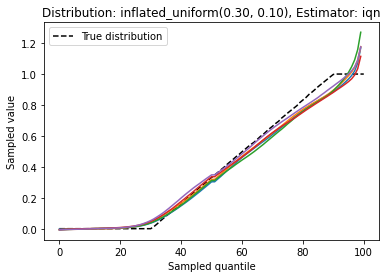

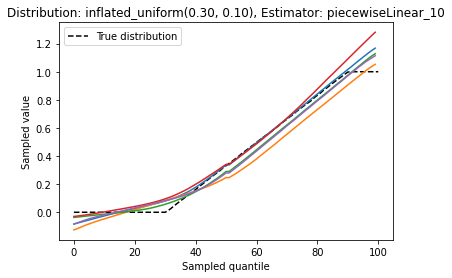

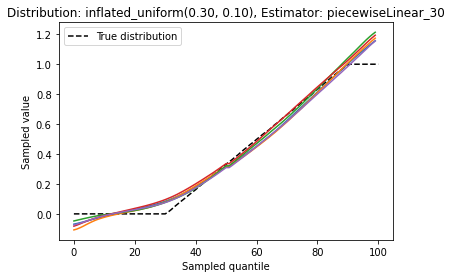

-------------------------------------------------
Distribution: inflated_uniform(0.30, 0.10), Estimator: iqn


,mean,amin,amax
MASE,1.252750,1.240582,1.265760
sMAPE,1.133834,1.108343,1.152849
MSIS,4.228221,4.162235,4.316311
mean_wQuantileLoss,0.592297,0.589081,0.596504
wQuantileLoss[0.1],0.201613,0.200769,0.202646
wQuantileLoss[0.5],0.850116,0.845111,0.855024
wQuantileLoss[0.9],0.327497,0.321679,0.334789


-------------------------------------------------
Distribution: inflated_uniform(0.30, 0.10), Estimator: piecewiseLinear_10


,mean,amin,amax
MASE,1.253140,1.247142,1.259910
sMAPE,1.162604,1.118736,1.215398
MSIS,4.561797,4.284471,4.741787
mean_wQuantileLoss,0.599935,0.594432,0.606109
wQuantileLoss[0.1],0.213853,0.207700,0.221635
wQuantileLoss[0.5],0.854608,0.849601,0.856508
wQuantileLoss[0.9],0.336748,0.326371,0.357406


-------------------------------------------------
Distribution: inflated_uniform(0.30, 0.10), Estimator: piecewiseLinear_30


,mean,amin,amax
MASE,1.255334,1.243388,1.273043
sMAPE,1.125735,1.112772,1.130718
MSIS,4.567999,4.463788,4.650367
mean_wQuantileLoss,0.597129,0.593795,0.599015
wQuantileLoss[0.1],0.210304,0.208990,0.211542
wQuantileLoss[0.5],0.847459,0.843431,0.850701
wQuantileLoss[0.9],0.338442,0.331941,0.348615


-------------------------------------------------
Distribution: inflated_uniform(0.30, 0.10), Estimator: iqn


,mean,amin,amax
Coverage[0.1],0.127200,0.048833,0.185667
Coverage[0.2],0.262833,0.211833,0.284500
Coverage[0.3],0.325767,0.322167,0.332833
Coverage[0.4],0.405333,0.394333,0.422167
Coverage[0.5],0.495667,0.486667,0.506667
Coverage[0.6],0.579633,0.560500,0.588667
Coverage[0.7],0.675067,0.652000,0.690333
Coverage[0.8],0.766600,0.747167,0.780833
Coverage[0.9],0.853400,0.835333,0.870167
wQuantileLoss[0.1],0.201613,0.200769,0.202646


-------------------------------------------------
Distribution: inflated_uniform(0.30, 0.10), Estimator: piecewiseLinear_10


,mean,amin,amax
Coverage[0.1],0.077200,0.015000,0.208667
Coverage[0.2],0.285333,0.230833,0.325667
Coverage[0.3],0.353867,0.335000,0.365500
Coverage[0.4],0.404200,0.395333,0.423500
Coverage[0.5],0.479367,0.445000,0.503833
Coverage[0.6],0.564267,0.520667,0.589833
Coverage[0.7],0.673467,0.620667,0.704333
Coverage[0.8],0.783867,0.723833,0.827167
Coverage[0.9],0.908400,0.834333,0.965833
wQuantileLoss[0.1],0.213853,0.207700,0.221635


-------------------------------------------------
Distribution: inflated_uniform(0.30, 0.10), Estimator: piecewiseLinear_30


,mean,amin,amax
Coverage[0.1],0.118633,0.066500,0.175167
Coverage[0.2],0.314100,0.304333,0.323000
Coverage[0.3],0.356300,0.351833,0.363833
Coverage[0.4],0.417567,0.409167,0.429000
Coverage[0.5],0.497600,0.493833,0.506833
Coverage[0.6],0.578133,0.568500,0.591667
Coverage[0.7],0.686067,0.672667,0.704167
Coverage[0.8],0.804267,0.792667,0.818500
Coverage[0.9],0.936900,0.926833,0.952333
wQuantileLoss[0.1],0.210304,0.208990,0.211542


In [19]:
def plot_quantile_functions(all_sampled_quantiles):
    for serie in all_sampled_quantiles:
        plt.plot(serie)


def get_metrics(all_metrics, keys):
    agg_func = [np.mean, np.min, np.max]
    display(all_metrics[keys].agg(agg_func, axis=0).T)
    

def get_key_metrics(all_agg_metrics):
    KEY_METRICS = ["MASE", "sMAPE", "MSIS", "mean_wQuantileLoss", 
               "wQuantileLoss[0.1]", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    all_metrics = pd.DataFrame(all_agg_metrics)
    get_metrics(all_metrics, KEY_METRICS)
    
def get_quantile_metrics(all_agg_metrics):
    all_metrics = pd.DataFrame(all_agg_metrics)
    QUANTILE_METRICS = [c for c in all_metrics.columns if ("Coverage" in c) or ("wQuantile" in c)]
    get_metrics(all_metrics, QUANTILE_METRICS)
       
    
def compare_trainings(store_results, dataset_reference=DATASET_REFERENCES):
    for fn in dataset_reference:
        true_distribution = dataset_reference[fn]
        random_values = rcp.evaluate([('target', true_distribution)], length=10000)['target']
        true_quantiles = [np.quantile(random_values, q=q/100) for q in range(0, 101)]
        
        for dn in distr_outputs:
            all_sampled_quantiles = store_results[(fn, dn)]["all_sampled_quantiles"]
            plt.plot(true_quantiles, color="black", linestyle='dashed',)
            plot_quantile_functions(all_sampled_quantiles)
            plt.legend(["True distribution"])
            plt.xlabel("Sampled quantile")
            plt.ylabel("Sampled value")
            plt.title("Distribution: {}, Estimator: {}".format(fn, dn))
            plt.show()

        for dn in distr_outputs:
            all_agg_metrics = store_results[(fn, dn)]["all_agg_metrics"]
            print("-------------------------------------------------")
            print("Distribution: {}, Estimator: {}".format(fn, dn))
            get_key_metrics(all_agg_metrics)
        
        for dn in distr_outputs:
            all_agg_metrics = store_results[(fn, dn)]["all_agg_metrics"]
            print("-------------------------------------------------")
            print("Distribution: {}, Estimator: {}".format(fn, dn))
            get_quantile_metrics(all_agg_metrics)

compare_trainings(store_results)